# Performance of US Carriers and Airports between 2005-2008

## Investigation Overview
In this analysis I will show which airport and carrier performance in the United States, as well as the causes behind poor performance. Poor performance is defined by delays and cancellations. I will also take a deep dive into Boston's Logan Airport to better understand my home airport's performance.

## Dataset Overview
The dataset comprises 4 years of flight data from 2005-2008. There are 28,745,461 flights captured across 29 variables. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# load multiple datasets
df_05 = pd.read_csv('2005.csv')
df_06 = pd.read_csv('2006.csv')
df_07 = pd.read_csv('2007.csv')
df_08 = pd.read_csv('2008.csv')

In [3]:
# merge datasets into a single frame
frames = [df_05, df_06, df_07, df_08]
df = pd.concat(frames)

## Which carriers and airports conduct the most flights? 


### Busiest Carriers

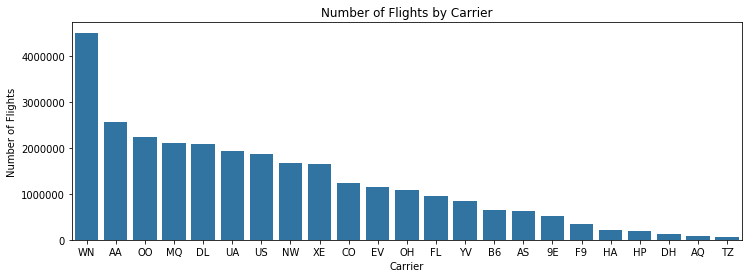

In [4]:
# Set the order by most flights to least flights
carrier_order = df['UniqueCarrier'].value_counts().index

# Remove color because this is a univariate exploration
base_color = sb.color_palette()[0]

# Plot
plt.figure(figsize=(12,4))
sb.countplot(data=df, x='UniqueCarrier', color=base_color, order=carrier_order)
plt.xlabel('Carrier')
plt.ylabel('Number of Flights')
plt.title('Number of Flights by Carrier');

It is immediately clear that the busiest carrier is __Southwest Airlines (WN)__. They have flown 43% more flights than the second busiest airline, American Airlines (AA). It is worth considering that Enjoy Air (code MQ) is part of the American Airlines group.

### Busiest Airports

In [5]:
# Set the order by most flights to least flights and limit to top 20
origin_order_20 = df['Origin'].value_counts().nlargest(20).index

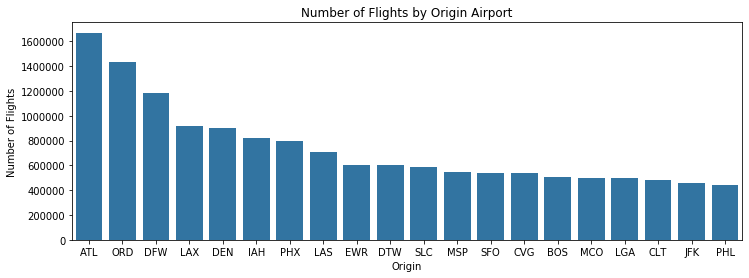

In [6]:
# Remove color because this is a univariate exploration
base_color = sb.color_palette()[0]

# Plot
plt.figure(figsize=(12,4))
sb.countplot(data=df, x='Origin', color=base_color, order=origin_order_20)
plt.ylabel('Number of Flights')
plt.xlabel('Origin')
plt.title('Number of Flights by Origin Airport');

It is no surprise that Atlanta and Chicago O'Hare are the busiest. I am considering a move to Denver. It has considerably more flights than Boston, which makes it a more attractive airport considering my extensive travel for work. It may lead to fewer connections and more direct flights.

## Which carriers have the worst average arrival delay?
It is critical to arrive on time whether travel is for work or vacation. Let's look into this crucial metric to understand carrier performance.

In [7]:
# Create a dateframe that summarizes data by carrier
by_carrier = df.groupby(['UniqueCarrier'], as_index=False)

# Get average delay values by carrier
avg_delay = by_carrier['CarrierDelay'].mean().sort_values(by='CarrierDelay', ascending=False)

# Create a new dataframe for the plot
df_delay = pd.DataFrame(avg_delay)

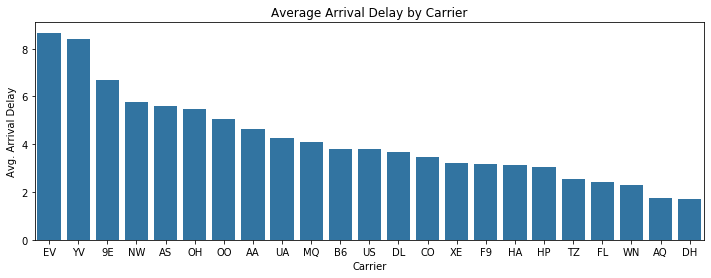

In [8]:

# Plot
base_color = sb.color_palette()[0]
plt.figure(figsize=(12,4))

sb.barplot(data=df_delay, x='UniqueCarrier', y='CarrierDelay', color=base_color)
plt.xlabel('Carrier')
plt.ylabel('Avg. Arrival Delay')
plt.title('Average Arrival Delay by Carrier');

We can see that ExpressJet (code EV) is the worse performing airline. They may want to think about changing their name. Southwest Airlines has the best record of the major carriers. Southwest Airlines is known to have the best operations management in the industry, so their performance is not surprising. 

My preferred airline, Delta, has a respectable performance. Now let's check out delay by airport.

### Airports with the most cancellations

In [9]:
# Which airports have the most cancellations?
by_airport = df.groupby(['Origin'], as_index=False)
total_cancellations = by_airport['Cancelled'].sum()
most_cancellations = total_cancellations.nlargest(10, columns='Cancelled')

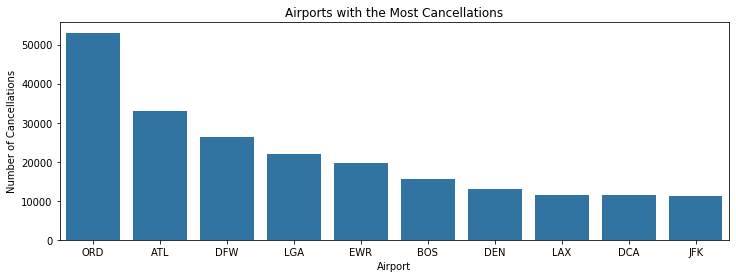

In [10]:
# Plot
base_color = sb.color_palette()[0]
plt.figure(figsize=(12,4))

sb.barplot(data=most_cancellations, x='Origin', y='Cancelled', color=base_color)
plt.title('Airports with the Most Cancellations')
plt.xlabel('Airport')
plt.ylabel('Number of Cancellations');

Chicago O'Hare (ORD) has the most cancellations by far despite Atlanta (ATL) being a substantially busier airport. It may be best to avoid flying from or through Chicago O'Hare.

### What Causes Cancellations at these airports?

In [11]:
# Capture the worse ten airports
worst_ten = ['ORD', 'ATL', 'DFW', 'LGA', 'EWR', 'BOS', 'DEN', 'LAX', 'DCA', 'JFK']

# Get the reason for cancellation by code across the worst ten airports

ccode = df.groupby(['Origin', 'CancellationCode']).size()
ccode = ccode.reset_index(name='count')
ccode_worst_ten = ccode[ccode.Origin.isin(worst_ten)]

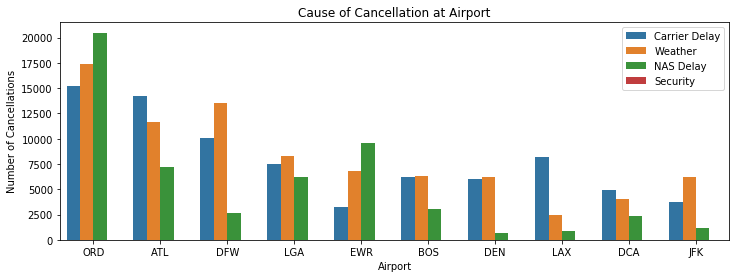

In [12]:
# Plot
airport_order = pd.api.types.CategoricalDtype(ordered=True, categories=worst_ten)
ccode_worst_ten['Origin'] = ccode_worst_ten['Origin'].astype(airport_order); 
plt.figure(figsize=(12,4))

sb.barplot(data=ccode_worst_ten, x='Origin', y='count', hue='CancellationCode')
plt.title('Cause of Cancellation at Airport')
plt.xlabel('Airport')
plt.ylabel('Number of Cancellations')
l=plt.legend()
l.get_texts()[0].set_text('Carrier Delay')
l.get_texts()[1].set_text('Weather')
l.get_texts()[2].set_text('NAS Delay')
l.get_texts()[3].set_text('Security');

We can clearly see that ORD suffers from NAS delays, which is weather that can slow down the system but shouldn't necessarily cause cancellations ([see reference](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)). Altanta suffers from carrier-caused delays, while weather is the next largest issue.

Security is not a really a factor for delays across any airport.

### Cancellations by Airport and Carrier

In [13]:
# capture these carriers in a list
twenty_carriers = ['WA', 'AA', 'OO', 'MQ', 'DL', 'UA', 'US', 'NW', 'XE', 'CO', 'EV', 'OH', 'FL', 'YV',
                  'B6', 'AS', '9E', 'F9', 'HA', 'HP']

# Create dataframe that captures cancellation grouped by carriers and airports
carrier_airport = df.groupby(by=['UniqueCarrier', 'Origin']).Cancelled.sum().reset_index()
carrier_airport_df = pd.DataFrame(carrier_airport)
carrier_airport_df.head()

# Filter dataframe to the top twenty busiest airports and carriers
carrier_airport_twenty = carrier_airport[carrier_airport_df['Origin'].isin(origin_order_20)]

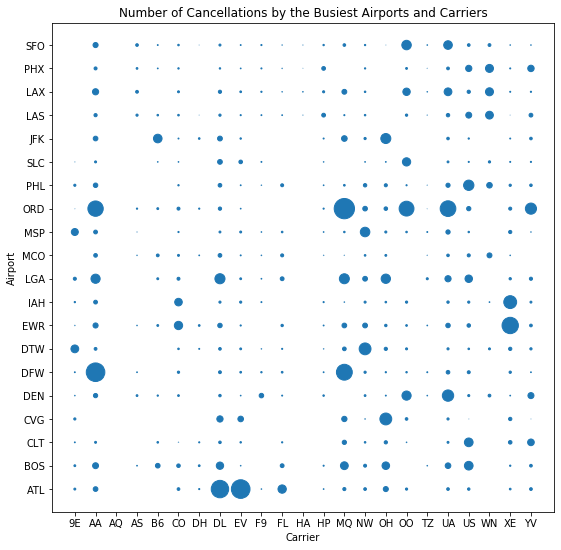

In [14]:
# plot
plt.figure(figsize=(9, 9))
plt.scatter(data=carrier_airport_twenty, x='UniqueCarrier', y='Origin', s=carrier_airport_twenty['Cancelled']/40)
plt.title('Number of Cancellations by the Busiest Airports and Carriers')
plt.xlabel('Carrier')
plt.ylabel('Airport');

This quickly shows that there are some risky airport/carrier combinations. For instance, travelers may want to avoid flying American Airlines (AA) out of Dallas (DFW), while Delta (DL) out of Boston (BOS) is safe (this is my preferred routine!)

### Departure Delays Across Very Busy to Very Slow Airports

In [15]:
airport_flights = df['Origin'].value_counts()
df_airport_flights = pd.DataFrame(airport_flights)

# Define a function to populate a new column that define each airport across a category
def f(row):
    if float(row['Origin']) > 59545:
        val = 'Very Busy'
    elif float(row['Origin']) <= 59545 & row['Origin'] > 14756:
        val = 'Busy'
    elif float(row['Origin']) <= 14756 & row['Origin'] > 4208:
        val = 'Slow'
    else:
        val = 'Very Slow'
    return val

# Add the calculated string values to a new dataframe
df_airport_flights['AirportTraffic'] = df_airport_flights.apply(f, axis=1)

# Reset the index so I can merge the two dataframes on 'Origin'
df_airport_flights.reset_index(inplace=True)
df_airport_flights.head()

# Rename columns
df_airport_flights.rename(columns={'index': 'Origin', 'Origin': 'TotalFlights'}, inplace=True)

# Merge these dataframes so I can do an analysis that groups airports by traffic volume
df_merge = df.merge(df_airport_flights, on='Origin', how='left')

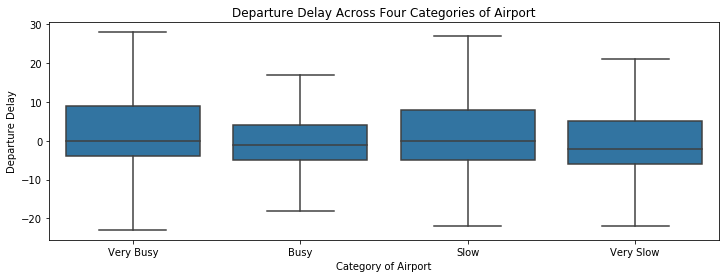

In [16]:
#Plot
traffic_classes = ['Very Busy', 'Busy', 'Slow', 'Very Slow']
tclasses = pd.api.types.CategoricalDtype(ordered=True, categories=traffic_classes)

df_merge['AirportTraffic'] = df_merge['AirportTraffic'].astype(tclasses); 

plt.figure(figsize=(12,4))
sb.boxplot(data=df_merge, x='AirportTraffic', y='DepDelay', showfliers=False, color=base_color)
plt.title('Departure Delay Across Four Categories of Airport')
plt.xlabel('Category of Airport')
plt.ylabel('Departure Delay');

The mean departure delay is nearly identical across all types of airports.'Busy' airports have the most stability, while 'Very Busy' airports have the least.

## A Look into Boston's Logan Airport

In [17]:
# Create dataframe filtered on Boston
boston_df = df[df['Origin'] == 'BOS']

### Boston's Busiest Airlines

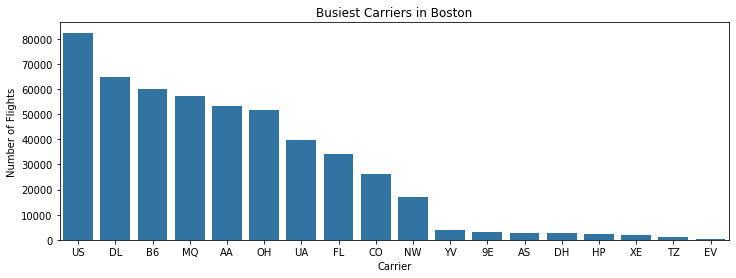

In [18]:
plt.figure(figsize=(12,4))
sb.countplot(data=boston_df, x='UniqueCarrier', color=base_color, 
             order=boston_df.UniqueCarrier.value_counts().index)
plt.title('Busiest Carriers in Boston')
plt.xlabel('Carrier')
plt.ylabel('Number of Flights');

US Airways has by far the most flights out of Boston, while my preferred airline, Delta, comes in at number two.

### Are Cancellations in Boston Seasonal?

In [19]:
# Create a dataframe that captures cancellations by month for Boston
boston_cancel = boston_df.groupby(['Month']).Cancelled.sum()
boston_cancel = boston_cancel.reset_index(name='Cancelled')

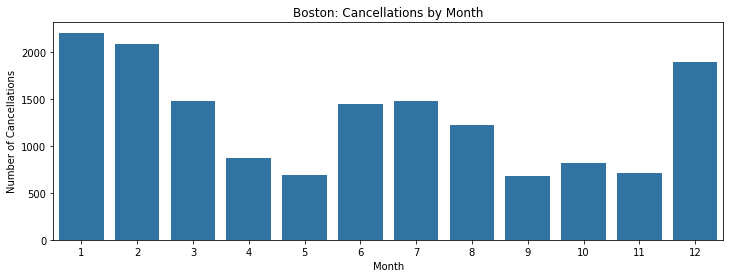

In [20]:
plt.figure(figsize=(12,4))
sb.barplot(data=boston_cancel, x='Month', y='Cancelled', color=base_color)
plt.title('Boston: Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations');

This is no surprise. Winter causes lots of problems for Boston's Logan Airport. December through February are tough months! But let's see if these cancellations are actually caused by weather as I assume.

### Causes of Cancellations in Boston

In [21]:
# Create dataframe that captures month, cancellation code, and number of cancellations for Boston
boston_cancel_type = boston_df.groupby(['Month', 'CancellationCode']).size()
boston_cancel_type = boston_cancel_type.reset_index(name='count')

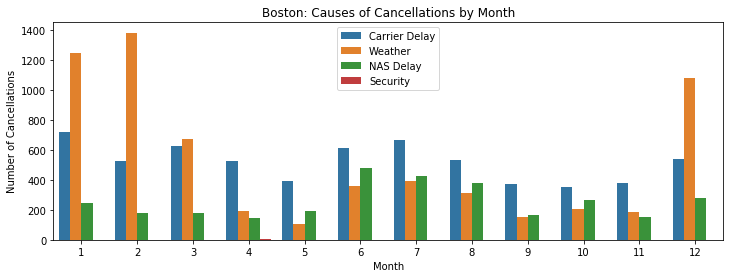

In [22]:
plt.figure(figsize=(12, 4))
sb.barplot(data=boston_cancel_type, x='Month', y='count', hue='CancellationCode')
plt.title('Boston: Causes of Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
l=plt.legend()
l.get_texts()[0].set_text('Carrier Delay')
l.get_texts()[1].set_text('Weather')
l.get_texts()[2].set_text('NAS Delay')
l.get_texts()[3].set_text('Security');

As suspected, weather accounts for the cancellations during the winter.